In [3]:
import numpy as np
from groundlight import Groundlight
import glob
import cv2
import matplotlib.pyplot as plt
import os

In [155]:
# Load the API client. This defaults to the prod endpoint,
# but you can specify a different endpoint like so:
#gl = Groundlight(endpoint="https://device.integ.positronix.ai/device-api")

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'

gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)

# Call an API method (e.g., retrieve a list of detectors)
detectors = gl.list_detectors()

det = detectors.results[0]

In [379]:
def sweepLocalize(img):
    imgDims = np.array([img.shape[1],img.shape[0]])
    kernelDims = (imgDims*2/3).astype(int)
    sweepDims = (imgDims/4).astype(int)
    colSweeps, rowSweeps = np.round(imgDims/sweepDims).astype(int) - 1
    for col in range(colSweeps):
        for row in range(rowSweeps):
            pxStart = sweepDims * np.array([col, row])
            pxEnd = pxStart + kernelDims
            sliceImg = img[pxStart[1]:pxEnd[1],pxStart[0]:pxEnd[0],:]
            
            imgDir = 'images/cubes/slices/{}'.format(imgNum)
            if not os.path.exists(imgDir):
                os.mkdir(imgDir)
            
            sliceName = 'images/cubes/slices/{}/sliceImg{}{}.jpg'.format(imgName[27:31],col,row)
            cv2.imwrite(sliceName,sliceImg)
            image_query = gl.submit_image_query(detector_id=det.id, image = sliceName)
            if image_query.result.label == 'PASS' and image_query.result.confidence > 0.7:
                
                plt.imshow(cv2.cvtColor(sliceImg, cv2.COLOR_RGB2BGR))
                plt.show()
                return (pxStart, np.minimum(pxEnd, imgDims), sweepLocalize(sliceImg))
    return None

In [380]:
def assemblePxTree(oldPx, tree):
    newPx = oldPx + tree[0]
    if(tree[2]) is None:
        newPx += ((tree[1] - tree[0])/2).astype(int)
        return newPx
    return assemblePxTree(newPx, tree[2])

In [331]:
allCubeImgs = sorted(glob.glob("images/cubes/training/*"))

In [393]:
imgName = allCubeImgs[8]

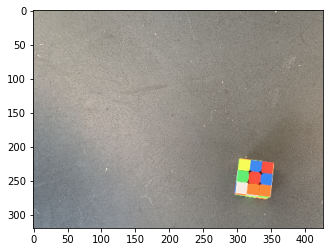

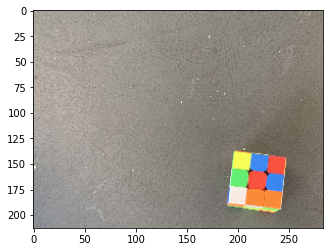

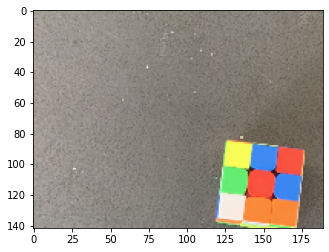

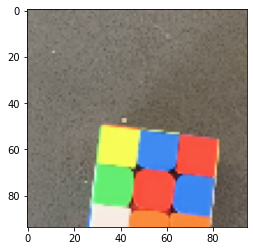

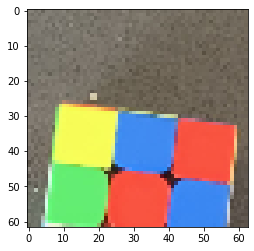

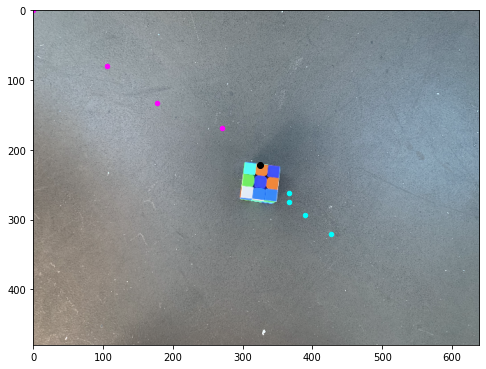

In [394]:
imgNum = imgName[27:31]

img = cv2.imread(imgName)
rszImg = cv2.resize(img,(imgDims[0],imgDims[1]))

tree = sweepLocalize(rszImg)

fig, ax = plotTreeOnImage(tree, rszImg)

In [234]:
def plotTreeOnImage(tree, img):
    fig, ax = plt.subplots(1,1, figsize = (8,10))
    ax.imshow(img)
    plotTreeOnImageHelper(ax, tree, np.array([0,0]))
    return fig, ax
                           
def plotTreeOnImageHelper(ax, tree, prevPx):
    if tree[2] is None:
        center = prevPx + ((tree[0] + tree[1])/2).astype(int)
        ax.scatter([center[0]], [center[1]], color = 'black')
        return
    ax.scatter([tree[0][0] + prevPx[0]],[tree[0][1]  + prevPx[1]],marker = 'o', s = 20, color = 'magenta')
    ax.scatter([tree[1][0]  + prevPx[0]],[tree[1][1]  + prevPx[1]],marker = 'o', s = 20, color = 'cyan')
    prevPx += tree[0]
    plotTreeOnImageHelper(ax, tree[2], prevPx)

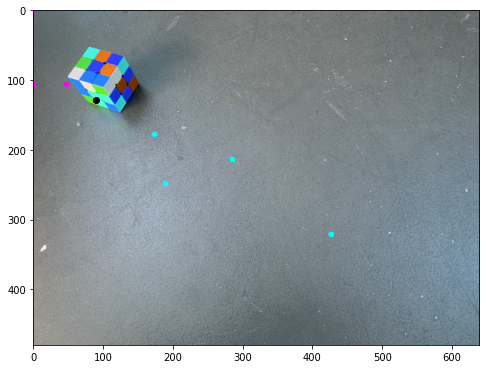

In [213]:
sliceName = 'images/cubes/slices/6197/sliceImg02.jpg'
image_query = gl.submit_image_query(detector_id=det.id, image = sliceName)